In [1]:
import tqdm
import math
import optuna
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import KBinsDiscretizer
from category_encoders import BinaryEncoder, one_hot
from sklearn.model_selection import train_test_split, StratifiedKFold

/home/gotheartem/Projects/ioai-hw/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

In [4]:
train_df

,age,country,city,school,faculty,student_id,sociodemographics,test_score,application_id,personal_statement,accepted
0,24,Россия,Санкт-Петербург,9,0,7127004,1f63c614a798186e5b5dbca02201a070,21.0,06c4288fba116e49f49d82a16184fca6,NaN,0.0
1,21,Казахстан,Астана,5,0,6264436,99fec0c12216abee9eec3bee2138754f,29.0,45273a0d372f7f2747afc98bdc63c31a,NaN,1.0
2,17,Россия,Тула,3,0,9056805,f733e24fc7ae975aab7c3e092b1ae96c,89.0,773c820049150b6854691b5e7fdcd63f,NaN,0.0
3,20,Украина,Киев,1,0,8857612,a2b7795cd58502654754ce03163a1685,2.0,d07f757f1b51f8b9189a84298b142794,NaN,0.0
4,19,Россия,Пермь,8,0,6422527,90519fbbfd457329160e9c1767cb0a86,23.0,269f19b2ef9f46af5012931bfd4acf22,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...
95995,21,Россия,Улан-Удэ,5,5,2019496,e065aa14d0861cb2e8c227049bc0b1d3,73.0,4c33d89befc11bea800221a9d8719549,NaN,1.0
95996,18,Казахстан,Шымкент,9,5,1202270,de6753fb488b87117296d8bef2edc7b3,91.0,b76e187984d8b80264b4c97fac124f84,NaN,0.0
95997,18,Россия,Владивосток,14,5,4114792,7ebd9ffcf2f9f0fbe6cfd54917af2098,31.0,750e34ebbf17be247c9184149109cbdd,NaN,1.0
95998,20,Украина,Запорожье,2,5,5024696,a2b7795cd58502654754ce03163a1685,45.0,0a17ffcb17a2ffd2eb185ac793ed444e,NaN,1.0


In [5]:
test_df

,ID,age,country,city,school,faculty,student_id,sociodemographics,test_score,application_id,personal_statement
0,96000,21,Россия,Санкт-Петербург,9,0,4428545,adcb62fdc1121af780dc4138486cc7e3,63.0,700db6161a195963a89ee91a11bc6449,NaN
1,96001,22,Казахстан,Астана,5,0,4828171,05ec3873d1ced60fb3d4327bfd368e00,62.0,c818a649e468d97325813b877fb7f308,NaN
2,96002,23,Россия,Тула,3,0,6305415,1533b17f2c49fec036550ee67955b0a6,17.0,0cc80bc0aa8531794601980c4c2f0fb7,NaN
3,96003,17,Украина,Киев,1,0,5175385,f1eef626c29a481a5527d242ae5516a8,25.0,ed05d43a670eea5a75662cc82d3a4b7d,NaN
4,96004,24,Россия,Пермь,8,0,1809466,67086df93882a3958b6163a60d0bd6b5,64.0,7b3e7852822d85f1de686caeb0c6307d,NaN
...,...,...,...,...,...,...,...,...,...,...,...
23995,119995,24,Украина,Запорожье,9,5,4222406,c35fb088b2e889aeb1f99fc9d21292a5,38.0,566ef31470ee65f6f9ab087dedee4f62,NaN
23996,119996,17,Украина,Запорожье,12,5,4382550,bfbca9e6c1e7d0b3e670af72336b6e60,90.0,0f67dbe83cb72c6b8b3bbb89c9cc6d02,NaN
23997,119997,17,Казахстан,Алматы,2,5,2780558,56b4da4b9f916a54be39f26757c8ce14,78.0,e8e86ee3af0ba2f4408c08a8f431b284,NaN
23998,119998,18,Казахстан,Астана,5,5,1773219,ce33a4a84820e71f4f0b507d574c4146,90.0,444d9437a6e57a722715af2feab9ce82,NaN


In [6]:
# PASHALKO #1
((pd.concat([train_df, test_df], axis=0).groupby(['sociodemographics', 'application_id'])['accepted'].agg('count') == 2) * (pd.concat([train_df, test_df], axis=0).groupby(['sociodemographics', 'application_id'])['accepted'].agg('sum')) == (pd.concat([train_df, test_df], axis=0).groupby(['sociodemographics', 'application_id'])['accepted'].agg('count') == 2).astype('float')).all()

True

In [7]:
# PASHALKO #2
train_df[train_df['test_score'] % 1 > 0].groupby(['student_id', 'application_id'])['accepted'].agg('max').min()

1.0

In [8]:
# train_df['application_id'] = train_df['application_id'].apply(lambda x: math.log(int(x, 16), 2)).astype(float)
# test_df['application_id'] = test_df['application_id'].apply(lambda x: math.log(int(x, 16), 2)).astype(float)

# PASHALKO #3
train_df['application_id'] = train_df['application_id'].apply(lambda x: int(x, 16))
test_df['application_id'] = test_df['application_id'].apply(lambda x: int(x, 16))

In [9]:
# PASHALKO #4
train_df['student_id_%'] = train_df['student_id'] % 100
test_df['student_id_%'] = test_df['student_id'] % 100

In [10]:
train_df['application_id_%'] = train_df['application_id'] % 250
test_df['application_id_%'] = test_df['application_id'] % 250

In [11]:
# train_df['cool_feature'] = train_df.groupby('faculty').cumcount() / (train_df.groupby('faculty').transform('size'))  ########################################
# test_df['cool_feature'] = test_df.groupby('faculty').cumcount() / (test_df.groupby('faculty').transform('size'))     ########################################

In [12]:
# PASHALKO #6
train_df['cool_feature'] = train_df.groupby('faculty').cumcount() / (train_df.groupby('faculty').transform('size'))
discretizer = KBinsDiscretizer(n_bins=40, encode='ordinal', strategy='uniform')
train_df['cool_feature'] = discretizer.fit_transform(train_df[['cool_feature']])[:, 0]
mapl = train_df.groupby('cool_feature')['accepted'].mean()
train_df['cool_feature'] = train_df['cool_feature'].apply(lambda x: mapl[x]) >= 0.7

test_df['cool_feature'] = test_df.groupby('faculty').cumcount() / (test_df.groupby('faculty').transform('size'))
test_df['cool_feature'] = discretizer.transform(test_df[['cool_feature']])[:, 0]
test_df['cool_feature'] = test_df['cool_feature'].apply(lambda x: mapl[x]) >= 0.7

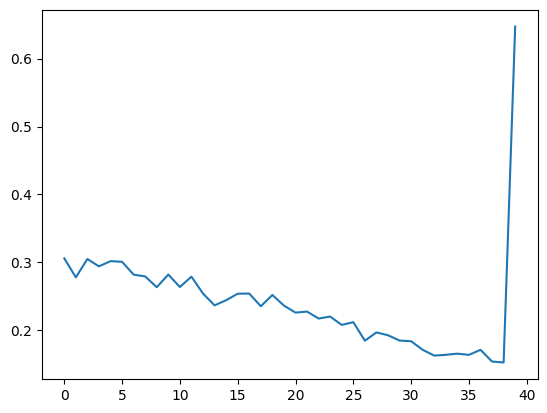

In [17]:
df_ = train_df[train_df['cool_feature'] == False].copy()
df_['cool_feature'] = df_.groupby('faculty').cumcount() / (df_.groupby('faculty').transform('size'))
df_['cool_feature'] = discretizer.transform(df_[['cool_feature']])[:, 0]
import matplotlib.pyplot as plt
plt.plot(df_.groupby('cool_feature')['accepted'].mean())

In [18]:
df_.groupby('cool_feature')['accepted'].mean()

cool_feature
0.0     0.305923
1.0     0.277941
2.0     0.304902
3.0     0.294118
4.0     0.301766
5.0     0.300833
6.0     0.281863
7.0     0.279275
8.0     0.263364
9.0     0.282001
10.0    0.263725
11.0    0.278922
12.0    0.254046
13.0    0.236649
14.0    0.244237
15.0    0.253797
16.0    0.254046
17.0    0.235294
18.0    0.251961
19.0    0.236275
20.0    0.225980
21.0    0.227451
22.0    0.217263
23.0    0.220098
24.0    0.207843
25.0    0.211869
26.0    0.184623
27.0    0.196762
28.0    0.192647
29.0    0.184804
30.0    0.183824
31.0    0.171162
32.0    0.162665
33.0    0.163806
34.0    0.165524
35.0    0.163725
36.0    0.171162
37.0    0.153922
38.0    0.152526
39.0    0.647405
Name: accepted, dtype: float64

In [15]:
train_df = train_df.drop(columns=['personal_statement'], axis=1)
test_df = test_df.drop(columns=['personal_statement'], axis=1)

In [16]:
# PASHALKO #5
binenc = BinaryEncoder(cols=['city', 'school', 'sociodemographics'])
ohenc = one_hot.OneHotEncoder(cols=['country', 'faculty', 'student_id_%', 'application_id_%'])
processed_train_df = ohenc.fit_transform(binenc.fit_transform(train_df)).sample(frac=1, random_state=42)

KeyboardInterrupt: 

In [ ]:
processed_train_df

In [59]:
class Ensemble:
    def __init__(self, models):
        self.models = models
    
    def predict(self, X):
        predictions_weighted_sum = np.full(len(X), 0.0)
        weights_sum = 0
        for model, weight in self.models:
            predictions_weighted_sum += model.predict_proba(X)[:, 1] * weight
            weights_sum += weight
        return predictions_weighted_sum / weights_sum

In [ ]:
main_model = Ensemble([
    [CatBoostClassifier(iterations=3000, verbose=0).fit(processed_train_df.drop(columns=['accepted'], axis=1), processed_train_df['accepted']), 1.0], 
])

In [ ]:
sub_models = {}
sub_binenc = BinaryEncoder(cols=['city', 'school', 'sociodemographics'])
sub_ohenc = one_hot.OneHotEncoder(cols=['country', 'faculty', 'student_id_%', 'application_id_%'])
sub_ohenc.fit(sub_binenc.fit_transform(train_df.drop(columns=['cool_feature'], axis=1)))
for feat_value in tqdm.tqdm(train_df['cool_feature'].unique()):
    train_df_part = train_df[train_df['cool_feature'] == feat_value].drop(columns=['cool_feature'], axis=1)
    train_df_part = sub_ohenc.transform(sub_binenc.transform(train_df_part))
    sub_models[feat_value] = Ensemble([
        [CatBoostClassifier(iterations=3000, verbose=0).fit(train_df_part.drop(columns=['accepted'], axis=1), train_df_part['accepted']), 1.0], 
    ])

In [21]:
test_df['accepted'] = np.full(len(test_df), 0)
sample_submission['accepted'] = main_model.predict(ohenc.transform(binenc.transform(test_df.drop(columns=['ID'], axis=1))).drop(columns=['accepted'], axis=1))

In [ ]:
for i in tqdm.tqdm(test_df.index):
    general_proba = sample_submission['accepted'][i]
    sub_proba = sub_models[test_df['cool_feature'][i]].predict(sub_ohenc.transform(sub_binenc.transform(test_df.loc[[i], :].drop(columns=['ID', 'cool_feature'], axis=1))).drop(columns=['accepted'], axis=1))
    if test_df['cool_feature'][i] == True: # upper
        sample_submission['accepted'][i] = (general_proba * 0.5 + sub_proba * 0.5) / (0.5 + 0.5)
    elif test_df['cool_feature'][i] == False: # lower
        sample_submission['accepted'][i] = (general_proba * 0.5 + sub_proba * 0.5) / (0.5 + 0.5)

In [ ]:
df_ = test_df.copy()
df_['accepted'] = sample_submission['accepted']
df_['cool_feature'] = df_.groupby('faculty').cumcount() / (df_.groupby('faculty').transform('size'))
df_['cool_feature'] = discretizer.transform(df_[['cool_feature']])[:, 0]
import matplotlib.pyplot as plt
plt.plot(df_.groupby('cool_feature')['accepted'].mean())

In [23]:
# # PASHALKO #6
# train_df['cool_feature'] = train_df.groupby('faculty').cumcount() / (train_df.groupby('faculty').transform('size'))
# discretizer = KBinsDiscretizer(n_bins=500, encode='ordinal', strategy='uniform')
# train_df['cool_feature'] = discretizer.fit_transform(train_df[['cool_feature']])[:, 0]
# mapl = train_df.groupby('cool_feature')['accepted'].mean()
# train_df['cool_feature'] = train_df['cool_feature'].apply(lambda x: mapl[x])

# test_df['cool_feature'] = test_df.groupby('faculty').cumcount() / (test_df.groupby('faculty').transform('size'))
# test_df['cool_feature'] = discretizer.transform(test_df[['cool_feature']])[:, 0]
# test_df['cool_feature'] = test_df['cool_feature'].apply(lambda x: mapl[x])

In [24]:
# socdem_pashalko_proba = train_df[train_df['cool_feature'] >= 0.7].groupby('sociodemographics')['accepted'].mean()
# for i in tqdm.tqdm(test_df.index):
#     general_proba = sample_submission['accepted'][i]
#     pashalko_proba = test_df.loc[[i], 'cool_feature']
#     if pashalko_proba.iloc[0] >= 0.7:
#         sample_submission['accepted'][i] = (general_proba * 0.9 + socdem_pashalko_proba[test_df['sociodemographics'][i]] * 0.1) / (0.9 + 0.1)

In [ ]:
for i in tqdm.tqdm(test_df.index):
    aplid = test_df['application_id'][i]
    socdem = test_df['sociodemographics'][i]
    trrel = train_df[(train_df['application_id'] == aplid) & (train_df['sociodemographics'] == socdem)]
    if len(trrel) == 1:
        if trrel['accepted'].iloc[0] == 0:
            sample_submission['accepted'][i] = 1.0
            continue
        elif trrel['accepted'].iloc[0] == 1:
            sample_submission['accepted'][i] = 0.0
            continue
    elif len(trrel) == 0:
        tsrel = test_df[(test_df['application_id'] == aplid) & (test_df['sociodemographics'] == socdem)]
        if len(tsrel) == 2:
            pp0 = sample_submission['accepted'][tsrel.index[0]]
            pp1 = sample_submission['accepted'][tsrel.index[1]]
            sample_submission['accepted'][tsrel.index[0]] = pp0 - ((pp0 + pp1 - 1) / 2)
            sample_submission['accepted'][tsrel.index[1]] = pp1 - ((pp0 + pp1 - 1) / 2)
            continue

In [26]:
sample_submission['accepted'][test_df['test_score'] % 1 > 0] = 1

In [27]:
sample_submission.to_csv('submission.csv', index=False)

In [ ]:
df_ = test_df.copy()
df_['accepted'] = sample_submission['accepted']
df_['cool_feature'] = df_.groupby('faculty').cumcount() / (df_.groupby('faculty').transform('size'))
df_['cool_feature'] = discretizer.transform(df_[['cool_feature']])[:, 0]
import matplotlib.pyplot as plt
plt.plot(df_.groupby('cool_feature')['accepted'].mean())